In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [6]:
# 1. 데이터 로딩 및 전처리
url = "https://raw.githubusercontent.com/Yana-one/AI_class/refs/heads/main/week6/diabetes.csv"
data = pd.read_csv(url)
print("✅ 데이터 로딩 완료")
data

✅ 데이터 로딩 완료


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [10]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [14]:
# 데이터와 타겟 분리
X = data.drop(['BMI','Outcome'], axis=1).values
y = data['BMI'].values

In [16]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((614, 7), (154, 7), (614,), (154,))

In [20]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [22]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 7), (154, 7), (614,), (154,))

In [26]:
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(7, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RegressionModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
# 학습 루프
model.train()
for epoch in range(50):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1, Loss: 1077.5447
Epoch 2, Loss: 1035.7182
Epoch 3, Loss: 960.9416
Epoch 4, Loss: 811.0460
Epoch 5, Loss: 617.5317
Epoch 6, Loss: 405.2806
Epoch 7, Loss: 220.6081
Epoch 8, Loss: 126.4786
Epoch 9, Loss: 104.4930
Epoch 10, Loss: 86.8570
Epoch 11, Loss: 80.2973
Epoch 12, Loss: 78.1170
Epoch 13, Loss: 73.3380
Epoch 14, Loss: 71.8253
Epoch 15, Loss: 69.9907
Epoch 16, Loss: 69.2913
Epoch 17, Loss: 65.2742
Epoch 18, Loss: 64.5021
Epoch 19, Loss: 70.3580
Epoch 20, Loss: 62.1340
Epoch 21, Loss: 60.7993
Epoch 22, Loss: 58.7119
Epoch 23, Loss: 57.0129
Epoch 24, Loss: 57.2396
Epoch 25, Loss: 56.0339
Epoch 26, Loss: 55.4817
Epoch 27, Loss: 52.9414
Epoch 28, Loss: 54.7745
Epoch 29, Loss: 52.1915
Epoch 30, Loss: 51.4583
Epoch 31, Loss: 49.9401
Epoch 32, Loss: 50.0781
Epoch 33, Loss: 48.9143
Epoch 34, Loss: 50.1472
Epoch 35, Loss: 47.5014
Epoch 36, Loss: 47.6792
Epoch 37, Loss: 48.4095
Epoch 38, Loss: 48.3426
Epoch 39, Loss: 45.6384
Epoch 40, Loss: 45.5898
Epoch 41, Loss: 43.7888
Epoch 42, Loss

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

model.eval()
preds, actuals = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).cpu().numpy()
        preds.extend(outputs)
        actuals.extend(y_batch.numpy())

mse = mean_squared_error(actuals, preds)
print(f"Test MSE: {mse:.4f}")

Test MSE: 51.3883


In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

actuals = np.array(actuals).flatten()
preds = np.array(preds).flatten()

print("Evaluation Metrics for Regression")
print(f"MAE: {mean_absolute_error(actuals, preds):.2f}")
print(f"MSE: {mean_squared_error(actuals, preds):.2f}")
print(f"R² Score: {r2_score(actuals, preds):.2f}")

Evaluation Metrics for Regression
MAE: 5.08
MSE: 51.39
R² Score: 0.13


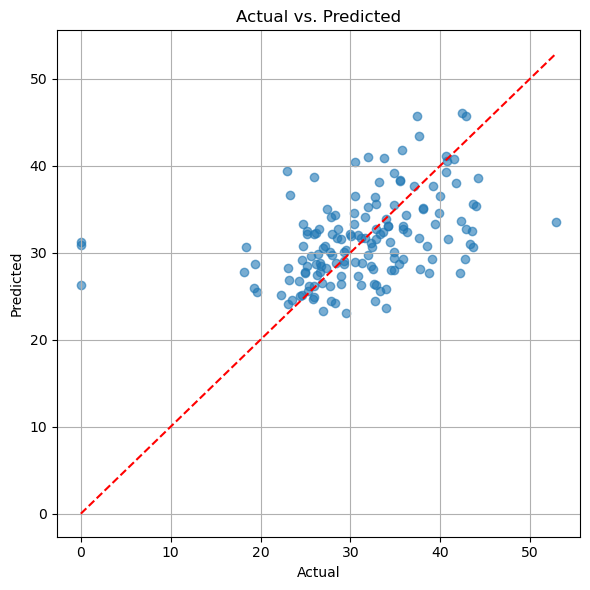

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(actuals, preds, alpha=0.6)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')  
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()